In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import butter, lfilter, freqz, bessel, filtfilt
from tqdm import tqdm
import iaaft

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF

import statsmodels.api as sm
import scipy
from scipy import signal
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)



# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
processed_data_folder = 'data/processed/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'


pca_1 = '1_pca/'
pca_2 = '2_pca_normalized/'
pca_3 = '3_pca_normalized_nmodes/'
pca_4 = '4_lowpass_ pca_normalized/'



# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Add reconstructed datasets - seed random

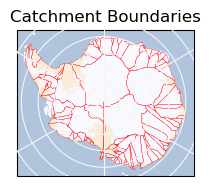

In [2]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [3]:
def butter_lowpass(cutoff, fs, order=1):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_new_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass_new_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

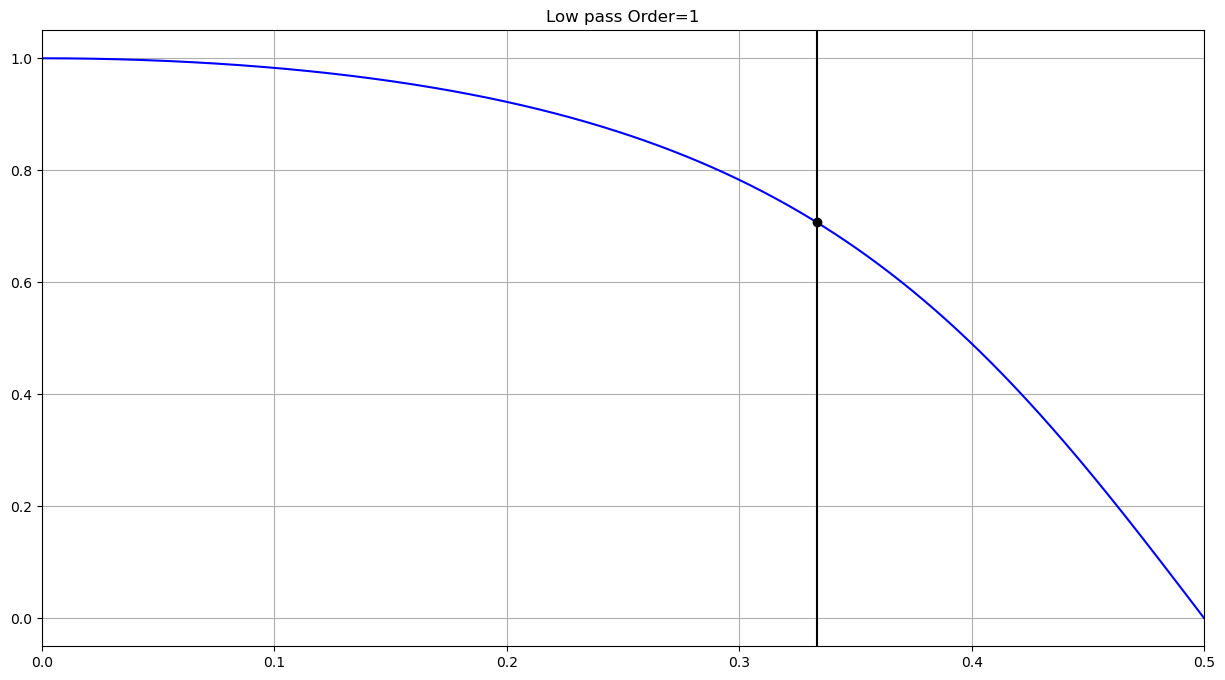

In [4]:
# Get the filter coefficients so we can check its frequency response.
# Filter requirements.
order = 1
fs = 1      # sample rate, Hz
nyq = 0.5 * fs
cutoff = 1/3  # desired cutoff frequency of the filter, Hz

bl, al = butter_lowpass(cutoff, fs, order=1)
wl, hl = freqz(bl, al, fs=fs, worN=8000)

plt.figure(figsize=(15,8))
plt.plot(wl, np.abs(hl), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Low pass Order={}".format(1))
plt.grid()


In [5]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [6]:
%%time
model = EOF(flux_clean_normalized) # change accordingly if using original data, or normalized data
#model = EOF(flux_clean) # change accordingly if using original data, or normalized data
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
#varexpl = model.explained_variance_ratio()

CPU times: user 57.5 s, sys: 21.8 s, total: 1min 19s
Wall time: 24.5 s


In [ ]:
nmodes = 1500

In [ ]:
eofs = xr.open_dataset(inDirName+processed_data_folder+pca_2+"norm_eofs.nc")
eofs = eofs.EOFs
pcs = xr.open_dataset(inDirName+processed_data_folder+pca_2+"norm_pcs.nc")
pcs = pcs.PCs

In [ ]:
%%time

np.random.seed(0)

##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 5
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        #fl_filt = butter_lowpass_filter(fl, cutoff, fs, order)
        fl_fourier = np.fft.rfft(fl)#(fl_filt)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

In [ ]:
nmodes_plot = 2 # Number of modes to plot
nrealizations_to_plot = 2 # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(25,20))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.5)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.5)
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', noverlap=120,NFFT=256,linewidth=0.25,label='Randomized')
    a0.plot(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a1.psd(pcs[:,i],color='k', noverlap=120,NFFT=256,linewidth=2.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

In [8]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def generate_noise(n_realization,mode,mode_skip):
    flux_reconstr_noise = model.reconstruct_randomized_X(new_fl_high[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr_noise


def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [9]:
flux_reconstr0 = generate_data(0, 1500, 1)
flux_reconstr0 = (flux_reconstr0*flux_clean_tstd)+flux_clean_tmean

#flux_reconstr1 = generate_data(1, 1500, 1)
#flux_reconstr1 = (flux_reconstr1*flux_clean_tstd)+flux_clean_tmean

In [13]:
filt_rec0 = butter_lowpass_filter(flux_reconstr0, cutoff, fs, order)

In [16]:
filt_rec0 = xr.DataArray(filt_rec0, dims=flux_clean.dims, coords=flux_clean.coords, attrs=flux_clean.attrs)

In [20]:
filt_rec0_ts = time_series(filt_rec0)

In [21]:
flux_clean_ts = time_series(flux_clean)

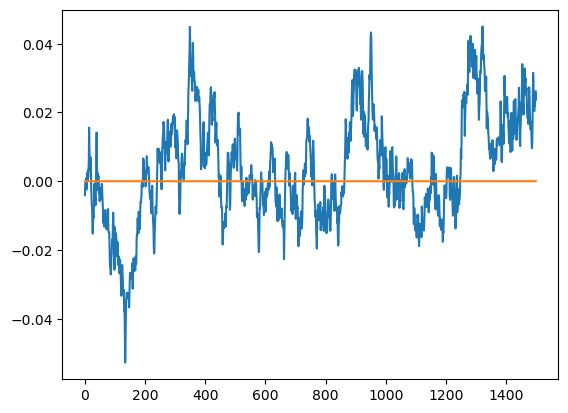

In [22]:
plt.plot(flux_clean_ts);
plt.plot(filt_rec0_ts);

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(2):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    #flux_reconstr = flux_reconstr + flux_clean_reconstr_noise
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"filt3/REC_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

In [ ]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+'filt3/REC_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

#flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+'iaaft/REC_1.nc')
#flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

In [ ]:
modes_used = [200, 500, 1500]
catchments = np.array([1,27,28,61,70,83])
#catchments = np.array([1,27,28,61])
basins = catchments+33
n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    orig = clip_data(flux_clean, basins[i])
    rec0 = clip_data(flux_reconstr0, basins[i])
    rec1 = clip_data(flux_reconstr1, basins[i])
    #rec2 = clip_data(flux_reconstr2, basins[i])
    orig = orig.rename('orig')
    rec0 = rec0.rename('rec0')
    rec1 = rec1.rename('rec1')
    #rec2 = rec2.rename('rec2')
    combined = xr.merge([orig,rec0, rec1])
    combined_ts = time_series(combined)
    a0.plot(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a0.plot(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a0.plot(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a1.psd(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a1.psd(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    del orig, rec0, rec1
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#plt.savefig(inDirName+processed_data_folder+pca_3+'generator-compare_{}-modes'.format(mode_number))
gc.collect()